# Capstone Project - Batalla de los Barrios -
# Abrir un restaurante de comida Brasilera en Miami

### Por: Wladimir Benavides

## Introducción
Este proyecto final explora las mejores ubicaciones para restaurantes brasileños en la de Miami. Este informe explora qué vecindarios y distritos de la ciudad de Miami tienen más y los mejores restaurantes brasileños. Además, intentaré responder a las preguntas "¿Dónde debo abrir un restaurante brasieño?" y "¿Dónde debo quedarme si quiero buena comida brasileña?"

## Audiencia Objetivo
Este proyecto está dirigido a Emprendedores o Dueños de Negocios que quieran abrir un nuevo Restaurante Brasileño en la ciudad de Miami o hacer crecer su negocio actual. El análisis proporcionará información vital que puede ser utilizada por el público objetivo.

## Datos
Los datos que se requerirán serán una combinación de archivos CSV que se han preparado para el análisis de múltiples fuentes que proporcionarán la lista de vecindarios en Miami (a través de Wikipedia), la ubicación geográfica de los vecindarios (a través del paquete Geocoder ) y Datos de lugares relacionados con restaurantes de comida brasileña (a través de Foursquare). Los datos del lugar ayudarán a encontrar qué barrio es el más adecuado para abrir un restaurante de comida brasileña.

Para responder a las preguntas anteriores, se requieren datos sobre los vecindarios de la ciudad de Miami, distritos que incluyan límites, latitud, longitud, restaurantes y calificaciones de restaurantes y consejos. Los datos de la ciudad de Miami que contienen los vecindarios y distritos, las latitudes y las longitudes se obtendrán de la fuente de datos: https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Miami.
Los datos de la ciudad de Miami que contengan los límites de los vecindarios se obtendrán de la fuente de datos: https://data.miamigov.com/Government/City-of-Miami-Service-Requests-Beta-/6q9s-asrs 
Todos los datos relacionados con las ubicaciones y la calidad de los restaurantes italianos se obtendrán a través de la API de FourSquare utilizada a través de la biblioteca Request en Python.

## Metodología
• Los datos se recopilarán de https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Miami y se limpiarán y procesarán en un marco de datos. 
• Se utilizará FourSquare para ubicar todos los lugares y luego se filtrará por restaurantes italianos. Las calificaciones, los consejos y los Me gusta de los usuarios se contarán y agregarán al marco de datos. 
• Los datos se ordenarán en función de las clasificaciones • Finalmente, los datos se evaluarán visualmente utilizando gráficos de varias bibliotecas de Python.

## Planteamiento del problema
¿Cuál es la mejor ubicación para disfrutar de la cocina brasileña en la ciudad de Miami?
¿En qué barrio y/o distrito debo abrir un restaurante brasileño para tener más posibilidades de éxito?
¿Adónde iría en la ciudad de Miami para disfrutar de la mejor comida brasileña?

## Paso 01 - Instalar e importar las librerías necesarias

In [5]:
## My Installs
!pip install BeautifulSoup4
!pip install lxml
!pip install geocoder
!pip install seaborn
!pip install wordcloud
!pip install sklearn --upgrade
!pip install folium --upgrade

## My Imports
import pandas as pd
from bs4 import BeautifulSoup
import requests ## Used to make requisitions
import geocoder ## Used to capture latitude e longitude from location
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import folium

import warnings
warnings.filterwarnings('ignore')

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=f0246ffeec374989a7b2fca82c0d0df79f5e93d3cd9752e7371242ffa10a4c2d
  Stored in directory: c:\users\wladimir\appdata\local\pip\cache\wheels\e4\7b\98\b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn
  Attempting uninstall: folium
    Found existing installation: folium 0.5.0
    Uninstalling folium-0.5.0:
      Successfully uninstalled folium-0.5.0


## Paso 02 - Preparación de los parámetros y funciones útiles

In [6]:
# PARAMETERS - API FOURSQUARE

CLIENT_ID = 'XHF5F4ELEBCHPZWQELVEFKYUCRORBHEQKK3XO43KOC2U0Z2N'
CLIENT_SECRET = 'XSL4HY52S3DOWZQ51WABH3M5QD5GAYP1A3PFNAGIGJNRYICD'
VERSION = '20180605'

# PARAMETERS - INIT FOLIUM

LOCATION_SPEC = '{}, FLORIDA, Miami City, EUA'
LATITUDE_MIAMI = 25.7825453
LONGITUDE_MIAMI = -80.2994988

In [7]:
## Función para capturar la latitud y longitud del Barrio

def get_latlng (neighborhood):
  
  lat_lng_coords = None 
  while (lat_lng_coords is None): 
      g = geocoder.arcgis (LOCATION_SPEC.format (neighborhood)) 
      lat_lng_coords = g.latlng 
  return lat_lng_coords

## Función para capturar los detalles de la API Foursquare

def get_venues(lat,lng):
    
  #set variables
  radius = 3000
  LIMIT = 100
  
  #url to fetch data from foursquare api
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
          CLIENT_ID, 
          CLIENT_SECRET, 
          VERSION, 
          lat, 
          lng, 
          radius, 
          LIMIT)
  
  # Tomar todos los datos
  results = requests.get(url).json()
  venue_data = results["response"]['groups'][0]['items']
  venue_details = []
  for row in venue_data:
      try:
          venue_id = row['venue']['id']
          venue_name = row['venue']['name']
          venue_category = row['venue']['categories'][0]['name']
          venue_origin = row['venue']['categories'][0]['shortName']
          venue_latitude = row['venue']['location']['lat']
          venue_longitude = row['venue']['location']['lng']
          venue_details.append([venue_id, venue_name, venue_category, venue_origin, venue_latitude, venue_longitude])
      except KeyError:
          pass
      
  column_names=['ID', 'Name', 'Category', 'Origin', 'Latitude', 'Longitude']
  df = pd.DataFrame(venue_details, columns = column_names)
  print("done!")
  return df

def get_info(id):

  #url to fetch data from foursquare api
  url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&v={}&client_secret={}'.format(
          id,
          CLIENT_ID, 
          VERSION, 
          CLIENT_SECRET)

  # get all the data
  result = requests.get(url).json()
  venue_info = result['response']

  return venue_info
  
def return_most_common_venues(row, num_top_venues):

  row_categories = row.iloc[1:]
  row_categories_sorted = row_categories.sort_values(ascending = False)

  return row_categories_sorted.index.values[0:num_top_venues]

## Paso 03 - Scraping de la Fuente de datos

In [8]:
response = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Miami')
soup = BeautifulSoup(response.content, 'lxml')
table = soup.find_all('table')[0]
data = pd.read_html(str(table))

source_table = pd.DataFrame(data[0])
source_table

,Neighborhood,Demonym,Population2010,Population/Km²,Sub-neighborhoods,Coordinates
0,Allapattah,NaN,54289,4401,NaN,".mw-parser-output .geo-default,.mw-parser-outp..."
1,Arts & Entertainment District,NaN,11033,7948,NaN,25°47′56″N 80°11′24″W﻿ / ﻿25.799°N 80.190°W
2,Brickell,Brickellite,31759,14541,West Brickell,25°45′29″N 80°11′35″W﻿ / ﻿25.758°N 80.193°W
3,Buena Vista,NaN,9058,3540,Buena Vista East Historic District and Design ...,25°48′47″N 80°11′31″W﻿ / ﻿25.813°N 80.192°W
4,Coconut Grove,Grovite,20076,3091,"Center Grove, Northeast Coconut Grove, Southwe...",25°42′43″N 80°15′25″W﻿ / ﻿25.712°N 80.257°W
5,Coral Way,NaN,35062,4496,"Coral Gate, Golden Pines, Shenandoah, Historic...",25°45′00″N 80°16′59″W﻿ / ﻿25.750°N 80.283°W
6,Design District,NaN,3573,3623,NaN,25°48′47″N 80°11′35″W﻿ / ﻿25.813°N 80.193°W
7,Downtown,Downtowner,"71,000 (13,635 CBD only)",10613,"Brickell, Central Business District (CBD), Dow...",25°46′26″N 80°11′35″W﻿ / ﻿25.774°N 80.193°W
8,Edgewater,NaN,15005,6675,NaN,25°48′07″N 80°11′24″W﻿ / ﻿25.802°N 80.190°W
9,Flagami,NaN,50834,5665,"Alameda, Grapeland Heights, and Fairlawn",25°45′43″N 80°18′58″W﻿ / ﻿25.762°N 80.316°W


## Paso 04 - Limpieza y preparación de datos
IMPORTANTE: Es en esta etapa donde más trabajaremos y dedicaremos más tiempo.

## 04.1 - Aislar solo nombres en una lista

In [9]:
unwanted = {'Downtown', 'Edgewater', 'Health District', 'Liberty City', 'Miami'} ## Remove Possible Trash 
list_neighborhood = source_table['Neighborhood']
list_neighborhood = [e for e in list_neighborhood if e not in unwanted]

list_neighborhood

['Allapattah',
 'Arts & Entertainment District',
 'Brickell',
 'Buena Vista',
 'Coconut Grove',
 'Coral Way',
 'Design District',
 'Flagami',
 'Grapeland Heights',
 'Little Haiti',
 'Little Havana',
 'Lummus Park',
 'Midtown',
 'Overtown',
 'Park West',
 'The Roads',
 'Upper Eastside',
 'Venetian Islands',
 'Virginia Key',
 'West Flagler',
 'Wynwood']

## 04.2 - Preparación, limpieza y clasificación con DataFrame (barrio, latitud, longitud y detalles)

In [10]:
columns_names = ['Neighborhood', 'Latitude', 'Longitude']
neighborhood_miami = pd.DataFrame(columns = columns_names)

for row in list_neighborhood:
  Neighborhood = row
  coords = get_latlng(Neighborhood)
  neighborhood_miami = neighborhood_miami.append({'Neighborhood':Neighborhood, 'Latitude':coords[0], 'Longitude':coords[1]}, ignore_index = True)

neighborhood_miami

,Neighborhood,Latitude,Longitude
0,Allapattah,25.80215,-80.22363
1,Arts & Entertainment District,10.50177,-66.87472
2,Brickell,25.757918,-80.192819
3,Buena Vista,25.81784,-80.19257
4,Coconut Grove,25.72785,-80.23411
5,Coral Way,25.75533,-80.22218
6,Design District,25.81278,-80.19211
7,Flagami,25.76271,-80.31587
8,Grapeland Heights,25.78889,-80.253426
9,Little Haiti,25.82864,-80.19833


## 04.3 - Buscando Restaurantes en Las Áreas

In [12]:
target = 'Restaurant'
columns_names = ['Neighborhood', 'ID', 'Name', 'Latitude', 'Longitude']
restaurants_miami = pd.DataFrame(columns = columns_names)
count=1

for row in neighborhood_miami.values.tolist():
  Neighborhood, Latitude, Longitude = row
  venues = get_venues(Latitude, Longitude)
  ##restaurants = venues[venues['Category'] == target]
  restaurants = venues[venues['Category'].str.contains(target)]
  print('(',count,'/',len(neighborhood_miami),')', 
        target + ' in ' + 
        Neighborhood + ': ' + 
        str(len(restaurants)))
  
  for detail in restaurants.values.tolist():
    id, name, category, food, lat, lng = detail
    restaurants_miami = restaurants_miami.append({
        'Neighborhood':Neighborhood, 'ID':id, 'Name':name, 
        'Category':category, 'Food':food, 
        'Latitude':lat, 'Longitude':lng}, ignore_index = True)
  count += 1

done!
( 1 / 21 ) Restaurant in Allapattah: 27
done!
( 2 / 21 ) Restaurant in Arts & Entertainment District: 35
done!
( 3 / 21 ) Restaurant in Brickell: 37
done!
( 4 / 21 ) Restaurant in Buena Vista: 30
done!
( 5 / 21 ) Restaurant in Coconut Grove: 35
done!
( 6 / 21 ) Restaurant in Coral Way: 36
done!
( 7 / 21 ) Restaurant in Design District: 27
done!
( 8 / 21 ) Restaurant in Flagami: 34
done!
( 9 / 21 ) Restaurant in Grapeland Heights: 28
done!
( 10 / 21 ) Restaurant in Little Haiti: 33
done!
( 11 / 21 ) Restaurant in Little Havana: 48
done!
( 12 / 21 ) Restaurant in Lummus Park: 37
done!
( 13 / 21 ) Restaurant in Midtown: 26
done!
( 14 / 21 ) Restaurant in Overtown: 25
done!
( 15 / 21 ) Restaurant in Park West: 1
done!
( 16 / 21 ) Restaurant in The Roads: 39
done!
( 17 / 21 ) Restaurant in Upper Eastside: 40
done!
( 18 / 21 ) Restaurant in Venetian Islands: 22
done!
( 19 / 21 ) Restaurant in Virginia Key: 13
done!
( 20 / 21 ) Restaurant in West Flagler: 36
done!
( 21 / 21 ) Restaurant

## 04.4 - Comprobación de datos - Todos los restaurantes

In [13]:
restaurants_miami = restaurants_miami.drop_duplicates(subset=['ID']).reset_index(drop = True) ## Remove items ID duplicates and reset index
restaurants_miami

,Neighborhood,ID,Name,Latitude,Longitude,Category,Food
0,Allapattah,4b80657df964a5207b6e30e3,Plaza Seafood Market,25.805638,-80.223992,Seafood Restaurant,Seafood
1,Allapattah,5f5002920b69a228a1f28be6,Leku,25.798761,-80.214333,Basque Restaurant,Basque
2,Allapattah,4b59e8fff964a5202ba028e3,Papo Llega y Pon,25.803466,-80.223886,Cuban Restaurant,Cuban
3,Allapattah,4c0fb252336220a1de29ce77,Miami Bakery,25.794406,-80.231769,Cuban Restaurant,Cuban
4,Allapattah,4e430a70c65bb758bc28bf43,El Palacio De Los Jugos,25.794963,-80.240045,Cuban Restaurant,Cuban
...,...,...,...,...,...,...,...
340,Wynwood,4ac6a54cf964a52099b520e3,Bali Cafe,25.775501,-80.190291,Indonesian Restaurant,Indonesian
341,Wynwood,57d2f255498e3aca32c8b021,Meraki Greek Bistro,25.77293,-80.192235,Greek Restaurant,Greek
342,Wynwood,4e36d74752b17fb1c6162ecf,La Granja,25.772736,-80.19006,Peruvian Restaurant,Peruvian
343,Wynwood,58d84463d0bb3e33b0e48e8b,Kiki On The River,25.777782,-80.204964,Restaurant,Restaurant


## 04.5 - Mostrar mapa - Todos los restaurantes

In [14]:
MIAMI_COORDINATES = (LATITUDE_MIAMI, LONGITUDE_MIAMI)
map_miami = folium.Map(location = MIAMI_COORDINATES, zoom_start = 11)

locations = restaurants_miami[['Latitude', 'Longitude']]
location_list = locations.values.tolist()

print("Number of point(s): " + str(len(location_list)))

for i in range(0, len(location_list)):

  point_name = restaurants_miami['Name'][i]
  point_yard = restaurants_miami['Neighborhood'][i]
  point_category = restaurants_miami['Category'][i]
  point_detail = '<b>' + point_name + '</b><br /><i>' + point_category + ' in '  + point_yard + '</i>'
  
  label = '{}'.format(point_detail)

  if (point_category == 'Brazilian Restaurant'):
    folium.Marker(
        location_list[i], 
        popup = point_detail, 
        tooltip = point_detail, 
        icon = folium.Icon(color='red')).add_to(map_miami)
  else:
    folium.Marker(
        location_list[i], 
        popup = point_detail, 
        tooltip = point_detail).add_to(map_miami)

folium.Circle([LATITUDE_MIAMI, LONGITUDE_MIAMI], radius = 20000).add_to(map_miami)
display(map_miami)

Number of point(s): 345


## 04.6 - Comprobación de datos - Solo restaurante brasileño

In [15]:
br_restaurants_miami = restaurants_miami[restaurants_miami['Category'].str.contains('Brazilian Restaurant')]
br_restaurants_miami = br_restaurants_miami.drop_duplicates(subset=['ID']).reset_index(drop = True) ## Remove items ID duplicates and reset index
br_restaurants_miami

,Neighborhood,ID,Name,Latitude,Longitude,Category,Food
0,Arts & Entertainment District,4d73e9449d2fa1430683e9d6,Amazonia Grill Restaurant,10.482431,-66.857548,Brazilian Restaurant,Brazilian
1,Upper Eastside,4ae2706ef964a5204d8e21e3,Boteco Miami,25.84792,-80.177723,Brazilian Restaurant,Brazilian


## 04.7 - Mostrar mapa - Restaurantes brasileños

In [16]:
map_miami_br = folium.Map(location = MIAMI_COORDINATES, zoom_start = 11)

locations = br_restaurants_miami[['Latitude', 'Longitude']]
location_list = locations.values.tolist()

print("Number of point(s): " + str(len(location_list)))

for j in range(0, len(location_list)):

  point_name = br_restaurants_miami['Name'][j]
  point_yard = br_restaurants_miami['Neighborhood'][j]
  point_category = br_restaurants_miami['Category'][j]
  point_detail = '<b>' + point_name + '</b><br /><i>' + point_category + ' in '  + point_yard + '</i>'

  folium.Marker(
      location_list[j], 
      popup = point_detail, 
      tooltip = point_detail, 
      icon = folium.Icon(color='green')).add_to(map_miami_br)
  
folium.Circle([LATITUDE_MIAMI, LONGITUDE_MIAMI], radius = 20000).add_to(map_miami_br)
display(map_miami_br)

Number of point(s): 2


## 04.6 - Comprobación de datos - Contador de categorías

In [17]:
restaurants_category = restaurants_miami.groupby('Food').size().reset_index(name='Count')
restaurants_category = restaurants_category.sort_values(by='Count', ascending = False).reset_index(drop = True) ## Remove items ID duplicates and reset index
restaurants_category

,Food,Count
0,Italian,44
1,Latin American,30
2,Cuban,28
3,Seafood,28
4,Mexican,23
5,Restaurant,20
6,American,17
7,Fast Food,14
8,Asian,11
9,Japanese,11


## 04.7 - Comprobación de datos - Contador de categorías por barrio

In [18]:
restaurants_neighborhood = restaurants_miami.groupby(['Neighborhood', 'Food']).size().reset_index(name='Count')
restaurants_neighborhood = restaurants_neighborhood.sort_values(by='Food', ascending = False).reset_index(drop = True)
restaurants_neighborhood

,Neighborhood,Food,Count
0,Little Haiti,Vietnamese,1
1,Little Haiti,Venezuelan,1
2,Venetian Islands,Vegetarian / Vegan,1
3,Allapattah,Vegetarian / Vegan,1
4,Upper Eastside,Vegetarian / Vegan,1
...,...,...,...
183,Buena Vista,American,1
184,Brickell,American,2
185,Little Haiti,American,2
186,Lummus Park,American,2


## 04.7 - Resumen

In [20]:
print('There are {} uniques categories.'.format(len(restaurants_miami['Category'].unique())))
print('There are {} restaurants.'.format(len(restaurants_miami['ID'].unique())))
print('There are {} restaurants brazilizan.'.format(len(br_restaurants_miami['ID'].unique())))

There are 43 uniques categories.
There are 345 restaurants.
There are 2 restaurants brazilizan.


## Paso 05 - Analizar

Luego, para analizar los datos, realizamos una técnica en la que los datos categóricos se transforman en datos numéricos para algoritmos de aprendizaje automático. Esta técnica se llama One hot encoding. Para cada uno de los vecindarios, los lugares individuales se convirtieron en la frecuencia de cuántos de esos lugares estaban ubicados en cada vecindario.

In [21]:
# one hot encoding
neighborhood_onehot = pd.get_dummies(restaurants_miami[['Food']], prefix="", prefix_sep="")
neighborhood_onehot['Neighborhood'] = restaurants_miami['Neighborhood']
fixed_columns = [neighborhood_onehot.columns[-1]] + list(neighborhood_onehot.columns[:-1])
neighborhood_onehot = neighborhood_onehot[fixed_columns]


neighborhood_grouped = neighborhood_onehot.groupby('Neighborhood').mean().reset_index()
neighborhood_grouped

,Neighborhood,American,Arepas,Argentinian,Asian,Basque,Brazilian,Cajun / Creole,Caribbean,Chinese,...,Southern / Soul,Spanish,Sushi,Tapas,Tex-Mex,Thai,Theme Restaurant,Vegetarian / Vegan,Venezuelan,Vietnamese
0,Allapattah,0.000000,0.000000,0.000000,0.111111,0.037037,0.000000,0.000000,0.037037,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.0000,0.0000
1,Arts & Entertainment District,0.000000,0.000000,0.000000,0.057143,0.000000,0.028571,0.000000,0.000000,0.085714,...,0.000000,0.057143,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000
2,Brickell,0.054054,0.000000,0.054054,0.081081,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.027027,0.027027,0.027027,0.027027,0.000000,0.000000,0.000000,0.0000,0.0000
3,Buena Vista,0.045455,0.045455,0.045455,0.045455,0.000000,0.000000,0.000000,0.090909,0.000000,...,0.000000,0.000000,0.045455,0.045455,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000
4,Coconut Grove,0.085714,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.028571,0.028571,0.028571,0.000000,0.028571,0.000000,0.028571,0.0000,0.0000
5,Coral Way,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,...,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000
6,Flagami,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117647,...,0.000000,0.088235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000
7,Grapeland Heights,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.045455,0.045455,0.090909,0.090909,0.000000,0.000000,0.000000,0.0000,0.0000
8,Little Haiti,0.125000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.062500,0.062500,0.000000,0.000000,0.000000,0.062500,0.0625,0.0625
9,Little Havana,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.0000,0.0000


In [22]:
num_top_venues = 5

for hood in neighborhood_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = neighborhood_grouped[neighborhood_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Allapattah----
        venue  freq
0   Fast Food  0.11
1     Mexican  0.11
2       Asian  0.11
3  Restaurant  0.11
4       Cuban  0.11


----Arts & Entertainment District----
           venue  freq
0        Italian  0.29
1     Restaurant  0.14
2  Mediterranean  0.09
3        Chinese  0.09
4        Spanish  0.06


----Brickell----
      venue  freq
0   Italian  0.22
1   Seafood  0.14
2  Japanese  0.11
3     Asian  0.08
4  Peruvian  0.08


----Buena Vista----
       venue  freq
0    Italian  0.18
1  Caribbean  0.09
2   American  0.05
3     French  0.05
4      Tapas  0.05


----Coconut Grove----
          venue  freq
0  New American  0.11
1      American  0.09
2       Italian  0.09
3    Portuguese  0.09
4         Cuban  0.09


----Coral Way----
            venue  freq
0  Latin American  0.38
1  South American  0.06
2         Spanish  0.06
3         Italian  0.06
4      Restaurant  0.06


----Flagami----
            venue  freq
0           Cuban  0.29
1  Latin American  0.12
2         

In [23]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neighborhood_grouped['Neighborhood']

for ind in np.arange(neighborhood_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allapattah,Fast Food,Mexican,Asian,Restaurant,Cuban
1,Arts & Entertainment District,Italian,Restaurant,Mediterranean,Chinese,Spanish
2,Brickell,Italian,Seafood,Japanese,Asian,Peruvian
3,Buena Vista,Italian,Caribbean,American,French,Tapas
4,Coconut Grove,New American,American,Italian,Portuguese,Cuban
5,Coral Way,Latin American,South American,Spanish,Italian,Restaurant
6,Flagami,Cuban,Latin American,Chinese,Fast Food,Spanish
7,Grapeland Heights,Cuban,Latin American,Tex-Mex,Tapas,Restaurant
8,Little Haiti,Italian,American,Venezuelan,Vegetarian / Vegan,Tapas
9,Little Havana,Latin American,Mexican,Cuban,Seafood,Thai


## Paso 06 - Analizar (Clasificación)

Pregunta: ¿Qué categoría/cocina aparece más?

<AxesSubplot:xlabel='count', ylabel='Food'>

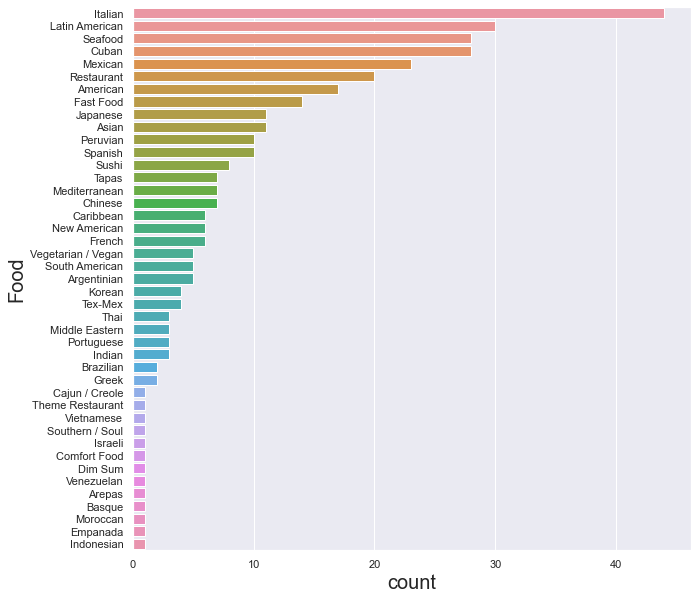

In [24]:
sns.set(rc = {"font.size":20, "axes.titlesize":20, "axes.labelsize":20, 'figure.figsize':(10,10)})
sns.countplot(y = "Food", data = restaurants_miami, order = restaurants_miami['Food'].value_counts().index)

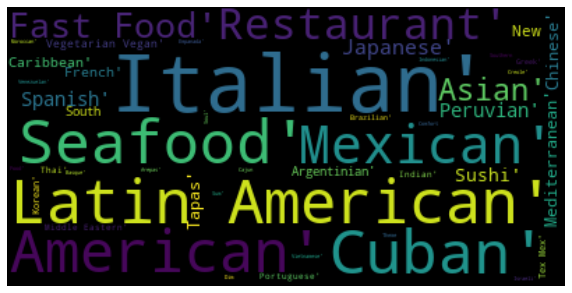

In [25]:
text = restaurants_miami['Food'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Paso 07 - Analizar (Clustering)

Pregunta: ¿Cuál es el número de cluster ideal?

In [26]:
K_clusters = range(1, 20)
kmeans = [KMeans(n_clusters = i) for i in K_clusters]
Y_axis = restaurants_miami[['Latitude']]
X_axis = restaurants_miami[['Longitude']]
distances = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

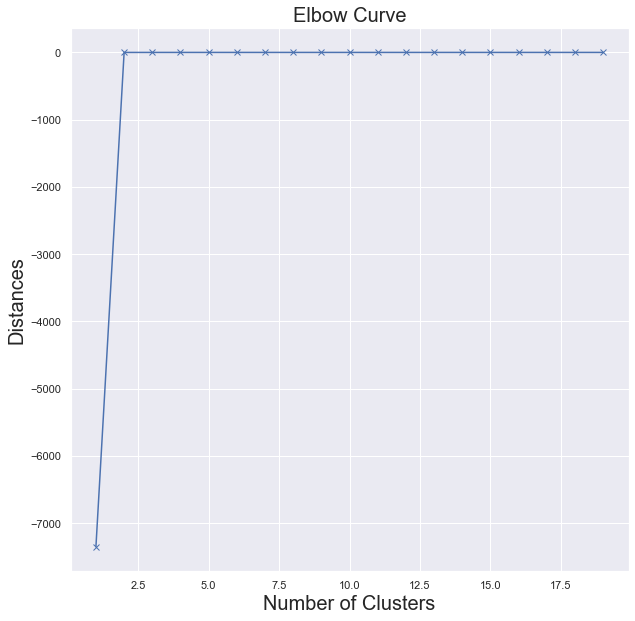

In [27]:
# Visualize
plt.plot(K_clusters, distances, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distances')
plt.title('Elbow Curve')
plt.show()

En el análisis de codo, el método del codo es una heurística utilizada para determinar el número de conglomerados en un conjunto de datos. El método consiste en trazar la variación explicada en función del número de conglomerados y elegir el codo de la curva como el número de conglomerados a utilizar. En nuestro caso aproximadamente 4,5. Pero utilicé 4.0.

In [28]:
neighborhood_clustering = restaurants_miami[['Food','Latitude','Longitude','Neighborhood']]
kclusters = 4

kmeans = KMeans(n_clusters = kclusters, init ='k-means++')
kmeans.fit(neighborhood_clustering[neighborhood_clustering.columns[1:3]])
neighborhood_clustering['Cluster Label'] = kmeans.fit_predict(neighborhood_clustering[neighborhood_clustering.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(neighborhood_clustering[neighborhood_clustering.columns[1:3]])
neighborhood_clustering

,Food,Latitude,Longitude,Neighborhood,Cluster Label
0,Seafood,25.805638,-80.223992,Allapattah,2
1,Basque,25.798761,-80.214333,Allapattah,2
2,Cuban,25.803466,-80.223886,Allapattah,2
3,Cuban,25.794406,-80.231769,Allapattah,0
4,Cuban,25.794963,-80.240045,Allapattah,0
...,...,...,...,...,...
340,Indonesian,25.775501,-80.190291,Wynwood,2
341,Greek,25.77293,-80.192235,Wynwood,0
342,Peruvian,25.772736,-80.19006,Wynwood,2
343,Restaurant,25.777782,-80.204964,Wynwood,0


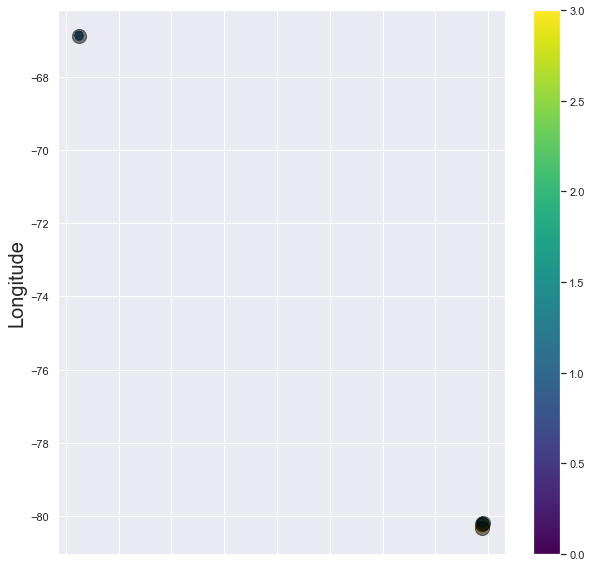

In [29]:
neighborhood_clustering.plot.scatter(x = 'Latitude', y = 'Longitude', c=labels, s = 50, cmap = 'viridis')
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5)

In [30]:
centers = kmeans.cluster_centers_
print(centers)

[[ 25.75796726 -80.22373138]
 [ 10.49545586 -66.86459748]
 [ 25.80799004 -80.17983824]
 [ 25.77186656 -80.32084152]]


## Montar Cluster de Datos

In [31]:
neighborhood_clustering = neighborhood_clustering.sort_values(by='Cluster Label', ascending = True).reset_index(drop = True)
neighborhood_clustering

,Food,Latitude,Longitude,Neighborhood,Cluster Label
0,Asian,25.764418,-80.19315,Brickell,0
1,Cuban,25.765835,-80.225167,Little Havana,0
2,Cuban,25.76559,-80.219207,Little Havana,0
3,Seafood,25.765871,-80.221476,Little Havana,0
4,Cuban,25.767856,-80.214189,Little Havana,0
...,...,...,...,...,...
340,Chinese,25.748405,-80.332519,Flagami,3
341,Cuban,25.763535,-80.294708,Flagami,3
342,Restaurant,25.777008,-80.30658,Flagami,3
343,Restaurant,25.748821,-80.303767,Flagami,3


In [32]:
neighborhood_merged = neighborhood_clustering
neighborhood_merged = neighborhood_clustering.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')
neighborhood_merged = neighborhood_merged.sort_values(by='Cluster Label', ascending = True).reset_index(drop = True)
neighborhood_merged

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Asian,25.764418,-80.19315,Brickell,0,Italian,Seafood,Japanese,Asian,Peruvian
1,Fast Food,25.811238,-80.239864,Allapattah,0,Fast Food,Mexican,Asian,Restaurant,Cuban
2,Restaurant,25.777782,-80.204964,Wynwood,0,Peruvian,Indonesian,Greek,Restaurant,Fast Food
3,Latin American,25.765147,-80.246825,Grapeland Heights,0,Cuban,Latin American,Tex-Mex,Tapas,Restaurant
4,Tapas,25.764547,-80.258195,Grapeland Heights,0,Cuban,Latin American,Tex-Mex,Tapas,Restaurant
...,...,...,...,...,...,...,...,...,...,...
340,Mexican,25.746907,-80.352406,West Flagler,3,Latin American,Mexican,American,Italian,Fast Food
341,American,25.769756,-80.359876,West Flagler,3,Latin American,Mexican,American,Italian,Fast Food
342,Mexican,25.769242,-80.359811,West Flagler,3,Latin American,Mexican,American,Italian,Fast Food
343,Chinese,25.769178,-80.337795,Flagami,3,Cuban,Latin American,Chinese,Fast Food,Spanish


## Mostrar mapa - Cluster

In [33]:
# create map
map_clusters = folium.Map(location = MIAMI_COORDINATES, tiles="cartodbpositron", zoom_start = 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

locations = neighborhood_merged[['Latitude', 'Longitude']]
location_list = locations.values.tolist()

for i in range(0, len(location_list)):

    point_name = neighborhood_merged['Food'][i]
    point_yard = neighborhood_merged['Neighborhood'][i]
    point_cluster = neighborhood_merged['Cluster Label'][i]
    point_detail = '<b>' + point_name + '</b><br /><i> Cluster ' + str(point_cluster) + ' in '  + point_yard + '</i>'

    folium.CircleMarker(
        location_list[i],
        radius = 5,
        popup = point_detail,
        color = rainbow[point_cluster - 1],
        fill = True,
        fill_color = rainbow[point_cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

## Cluster 1

In [34]:
## Cluster 1 in neighborhood_merged
neighborhood_cluster1 = neighborhood_merged[neighborhood_merged['Cluster Label'] == 0]
neighborhood_cluster1

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Asian,25.764418,-80.19315,Brickell,0,Italian,Seafood,Japanese,Asian,Peruvian
1,Fast Food,25.811238,-80.239864,Allapattah,0,Fast Food,Mexican,Asian,Restaurant,Cuban
2,Restaurant,25.777782,-80.204964,Wynwood,0,Peruvian,Indonesian,Greek,Restaurant,Fast Food
3,Latin American,25.765147,-80.246825,Grapeland Heights,0,Cuban,Latin American,Tex-Mex,Tapas,Restaurant
4,Tapas,25.764547,-80.258195,Grapeland Heights,0,Cuban,Latin American,Tex-Mex,Tapas,Restaurant
...,...,...,...,...,...,...,...,...,...,...
127,French,25.727652,-80.242798,Coconut Grove,0,New American,American,Italian,Portuguese,Cuban
128,Cuban,25.735124,-80.255926,Coconut Grove,0,New American,American,Italian,Portuguese,Cuban
129,Portuguese,25.750816,-80.23098,Coconut Grove,0,New American,American,Italian,Portuguese,Cuban
130,Japanese,25.749995,-80.243453,Coconut Grove,0,New American,American,Italian,Portuguese,Cuban


## Cluster 2

In [35]:
## Cluster 2 in neighborhood_merged
neighborhood_cluster2 = neighborhood_merged[neighborhood_merged['Cluster Label'] == 1]
neighborhood_cluster2

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
132,Chinese,10.497592,-66.867621,Arts & Entertainment District,1,Italian,Restaurant,Mediterranean,Chinese,Spanish
133,Italian,10.481825,-66.860367,Arts & Entertainment District,1,Italian,Restaurant,Mediterranean,Chinese,Spanish
134,Mediterranean,10.484858,-66.863115,Arts & Entertainment District,1,Italian,Restaurant,Mediterranean,Chinese,Spanish
135,Italian,10.496223,-66.879551,Arts & Entertainment District,1,Italian,Restaurant,Mediterranean,Chinese,Spanish
136,Italian,10.485488,-66.877956,Arts & Entertainment District,1,Italian,Restaurant,Mediterranean,Chinese,Spanish
137,Italian,10.489462,-66.868485,Arts & Entertainment District,1,Italian,Restaurant,Mediterranean,Chinese,Spanish
138,Chinese,10.497749,-66.867209,Arts & Entertainment District,1,Italian,Restaurant,Mediterranean,Chinese,Spanish
139,Mexican,10.493555,-66.852107,Arts & Entertainment District,1,Italian,Restaurant,Mediterranean,Chinese,Spanish
140,Restaurant,10.503328,-66.874169,Arts & Entertainment District,1,Italian,Restaurant,Mediterranean,Chinese,Spanish
141,Restaurant,10.500594,-66.886517,Arts & Entertainment District,1,Italian,Restaurant,Mediterranean,Chinese,Spanish


## Cluster 3

In [36]:
## Cluster 3 in neighborhood_merged
neighborhood_cluster3 = neighborhood_merged[neighborhood_merged['Cluster Label'] == 2]
neighborhood_cluster3

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
167,Japanese,25.819121,-80.1918,Buena Vista,2,Italian,Caribbean,American,French,Tapas
168,Italian,25.842441,-80.184123,Little Haiti,2,Italian,American,Venezuelan,Vegetarian / Vegan,Tapas
169,Asian,25.809132,-80.193461,Buena Vista,2,Italian,Caribbean,American,French,Tapas
170,Italian,25.829372,-80.187083,Buena Vista,2,Italian,Caribbean,American,French,Tapas
171,Mexican,25.827105,-80.187079,Buena Vista,2,Italian,Caribbean,American,French,Tapas
...,...,...,...,...,...,...,...,...,...,...
279,American,25.791501,-80.140009,Venetian Islands,2,American,Sushi,Peruvian,Italian,Vegetarian / Vegan
280,Vegetarian / Vegan,25.793187,-80.1409,Venetian Islands,2,American,Sushi,Peruvian,Italian,Vegetarian / Vegan
281,Southern / Soul,25.789092,-80.140154,Venetian Islands,2,American,Sushi,Peruvian,Italian,Vegetarian / Vegan
282,Sushi,25.793541,-80.142948,Venetian Islands,2,American,Sushi,Peruvian,Italian,Vegetarian / Vegan


## Cluster 4

In [37]:
## Cluster 4 in neighborhood_merged
neighborhood_cluster4 = neighborhood_merged[neighborhood_merged['Cluster Label'] == 3]
neighborhood_cluster4

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
284,Cuban,25.761632,-80.336486,Flagami,3,Cuban,Latin American,Chinese,Fast Food,Spanish
285,Latin American,25.747733,-80.31025,Flagami,3,Cuban,Latin American,Chinese,Fast Food,Spanish
286,Cuban,25.770311,-80.307487,Flagami,3,Cuban,Latin American,Chinese,Fast Food,Spanish
287,Cuban,25.748136,-80.304875,Flagami,3,Cuban,Latin American,Chinese,Fast Food,Spanish
288,Cuban,25.763426,-80.290791,Flagami,3,Cuban,Latin American,Chinese,Fast Food,Spanish
...,...,...,...,...,...,...,...,...,...,...
340,Mexican,25.746907,-80.352406,West Flagler,3,Latin American,Mexican,American,Italian,Fast Food
341,American,25.769756,-80.359876,West Flagler,3,Latin American,Mexican,American,Italian,Fast Food
342,Mexican,25.769242,-80.359811,West Flagler,3,Latin American,Mexican,American,Italian,Fast Food
343,Chinese,25.769178,-80.337795,Flagami,3,Cuban,Latin American,Chinese,Fast Food,Spanish


## Discusión

Como podemos ver en el análisis realizado, la mayoría de restaurantes brasileños basados en los 4 cluster creados se encuentran en el centro de Miami, y en Miami Beach. Haciendo el análisis de k-means, vemos que la mayoría de los restaurantes italianos están en el grupo rojo, que abarca el centro de la ciudad de la Miami, así como también existe un gran potencial, en el área de Miami Beach, y la parte norte de Miami, que se encuentra señalado con color celeste. Esas serían las zonas de mayor crecimiento potencial para poder ofrecer comida brasileña en Miami
Esto concluye los hallazgos óptimos para este proyecto y recomienda al emprendedor abrir un auténtico restaurante brasileño en estos lugares con poca o ninguna competencia.

## Conclusión
En conclusión, para finalizar este proyecto, tuvimos la oportunidad de aplicar los conocimientos adquiridos en un problema comercial, y se abordó de una manera similar a como lo haría un verdadero científico de datos. Utilizamos numerosas bibliotecas de Python para obtener la información, controlar el contenido y desglosar y visualizar esos conjuntos de datos. Hemos utilizado la API de Foursquare para investigar la configuración en los vecindarios de Toronto, obtener una gran cantidad de datos de Wikipedia que extrajimos con la biblioteca de raspado web Beautifulsoup. También visualizamos el uso de diferentes gráficos presentes en las bibliotecas Seaborn y Matplotlib. Del mismo modo, aplicamos la estrategia de IA para anticipar el error dada la información y utilizamos Folium para representarlo en un mapa.